# Anime Image Generation using GANS - Pytorch

- categories: [GANs]

# Introduction to Generative Modeling

Generative Adversarial Networks (GANs) use neural network for generative modeling,
It is an unsupervised learning task in machine learning that involves automatically discovering and learning the ragularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset ex:- [thispersondoesnotexist.com](https://thispersondoesnotexist.com/)


![GAN](https://www.kdnuggets.com/wp-content/uploads/generative-adversarial-network.png)

HOW this works bruh :

GAN have two different neural networks, **Generator network**(takes input a random vector and it generates an image) and **Discriminator network**(model whose job is to diffrentiate between real images which are drawn from dataset and generated images)

WAY the training works :

we train Discriminator on batches of both Real and Generated images so it should be good at discriminating,
              *we then use discriminator as a part of the loss function of the Generator* 
we take a generated image from the generator we pass them through the discriminator and we try to fool the discriminator, then update the generator.

**Generator tries to fool and Discriminator tries to catch the bluff**

![GAN2](https://drek4537l1klr.cloudfront.net/langr/Figures/01fig03_alt.jpg)

GANs are difficult to train and are extremely sensitive to hyperparameters, activation function and regularisation

More Resources: [off convex blog](http://www.offconvex.org/2020/07/06/GAN-min-max/),  [GANs and Divergence Minimization](https://colinraffel.com/blog/gans-and-divergence-minimization.html)

## Dataset : Anime Face Dataset --> https://www.kaggle.com/splcher/animefacedataset

In [1]:
project_name = 'anime-dcgan'

Download and Explore the dataset using opendatasets library
import opendatasets as od
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

In [2]:
import os

DATA_DIR = "./animefacedataset"
print(os.listdir(DATA_DIR))

['images']


In [3]:
print(os.listdir(DATA_DIR + "/images")[:10])

['23203_2008.jpg', '21344_2008.jpg', '50099_2015.jpg', '42947_2013.jpg', '59998_2018.jpg', '5180_2003.jpg', '27731_2009.jpg', '39250_2012.jpg', '13478_2006.jpg', '39408_2012.jpg']


In [4]:
# loading dataset from ImageFolder class in torchvision

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64    # crop images to 64x64 pixels
batch_size = 128

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # normalize the pixel values with mean and std deviation of 0.5, to get pixel value in range (-1,1)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

In [7]:
# helper functions to denormalize image tensors and display some sample images from a training batch

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def denorm(img_tensors):   #std=0.5     mean
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0)) #pytorch images have color channels in the first dimension, where as matplotlib require color channels to be in the last dimension so we permute
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
    

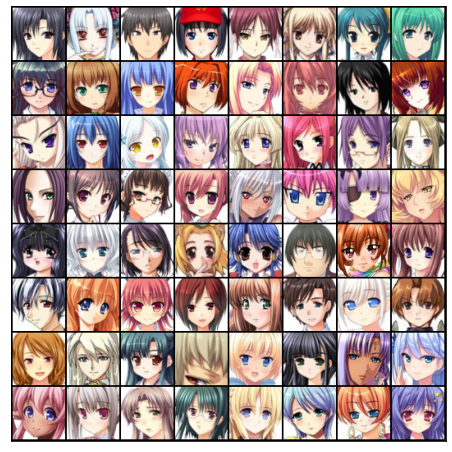

In [10]:
show_batch(train_dl)

## Utilities for working with GPUs

In [11]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl) 

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

it takes image as input and tries to classify is as 'real' or 'generated'. I'll use CNN with binary classification


![binary](https://www.researchgate.net/publication/338174593/figure/fig4/AS:840368614543361@1577370899145/Convolutional-Neural-Network-archtecture-for-binary-classification-referred-from-10.png)

Also we'll use Leaky ReLU as activation function and sigmod function too 

![relu](https://www.researchgate.net/publication/339991922/figure/fig4/AS:870241110339586@1584493057180/Plot-of-different-activation-functions-a-Sigmoid-activation-function-b-Tanh.ppm)

In [14]:
import torch.nn as nn

In [15]:
discriminator = nn.Sequential(
        
        # in: 3 x 64 x 64
       
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
      
        # out: 64 x 32 x 32
    
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
    
        # out: 128 x 16 x 16
    
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
    
        # out: 256 x 8 x 8
    
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
    
        # out: 512 x 4 x 4
        
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
        # out: 1 x 1 x 1
       
        nn.Flatten(),
        nn.Sigmoid()
        
)

Because we use discriminator as a part of the loss function to train the genrator, ReLU will lead to a lot of outputs from the generator being lost, so Leaky ReLU allows the pass of a gradient signal even for the negative value, that makes the gradients from the discriminator flows stronger into the generator.

so the idea here is,none of imformation whould get lost using discriminator and gradient function to train generator

In [16]:
discriminator = to_device(discriminator, device)

# Generator Network

input to generator is typically a vector or a matrix of random numbers (ie. latent tensor)

Generator will take a latent tensor of shape **(128, 1, 1)** and convert to an image tensor of shape **(3 x 28 x 28)**

To achive this we'll use **ConvTranspose2d** Layer from pytorch, which performs as a transposed convolution of deconvolution

To get a better understanding of Transposed Convolution

also read this [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![TC1](https://miro.medium.com/max/2000/1*L_hJRnywTpeTFJAaVZTRfQ.gif)
![TC2](https://miro.medium.com/max/1972/1*yoQ62ckovnGYV2vSIq9q4g.gif)
![TC3](https://www.researchgate.net/profile/Jan-Egger-2/publication/331541434/figure/fig6/AS:733268576063488@1551836260118/Comparison-between-normal-convolution-and-transposed-convolution-Both-operations-use-a.png)

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    
    # out: 3 x 64 x 64
)

we are using tanh():
![tanh](https://rhv.em7565algab.pw/img/pytorch-tanh.gif)

hyperbolic tangent activation function  : reduces values into the range -1 to 1 --> when 3 x 64 x 64 feature map is generated from convtranspose2d its values can range between -infy to infy , so it convert them to -1 to 1 so that outputs of images are in range -1 to 1 

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


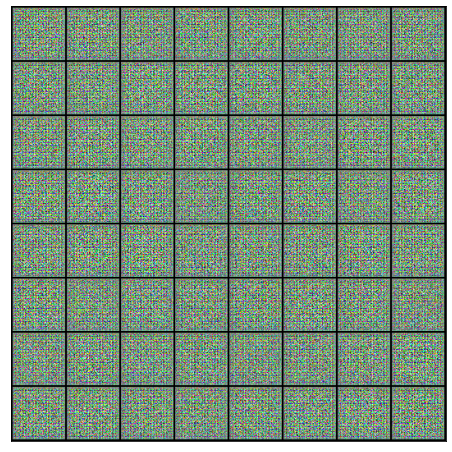

In [19]:
# lets try our generator function

xb = torch.randn(batch_size, latent_size, 1, 1)  # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

# Discriminator Training

as the Discriminator is a binary classifier, we can use binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images

![cross](https://miro.medium.com/max/3648/1*wz59MnXkXdWxrq_fkA2wew.png)

In [21]:
def train_discriminator(real_images, opt_d):
    
    # clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through the discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. 

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.



In [32]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #try to fool the discriminator
    preds = discriminator(fake_images)
    targets  = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    #update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()
    

In [23]:
# saving and exporting generated images

from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_sample(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
# we'll use fixed set of i/p vectors to the generator to see how the individual generated images evolve over time as we train our model
# save one set of images before start training our model

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


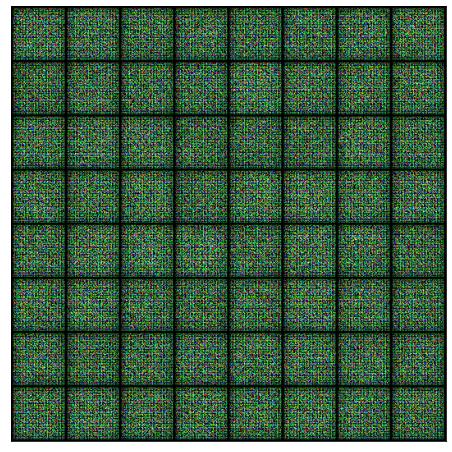

In [27]:
save_sample(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

![image](https://i.imgur.com/6NMdO9u.png)


In [28]:
from tqdm import tqdm
import torch.nn.functional as F

In [29]:
def fit(epoch, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
             
        # Record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # log losses and scores (last batch)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_sample(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 10

In [33]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.7820, loss_d: 0.7976, real_score: 0.9692, fake_score: 0.5054
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.3187, loss_d: 0.5204, real_score: 0.8973, fake_score: 0.3050
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.3551, loss_d: 0.6221, real_score: 0.6364, fake_score: 0.0227
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.2019, loss_d: 0.2498, real_score: 0.8556, fake_score: 0.0619
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.7978, loss_d: 0.1832, real_score: 0.8876, fake_score: 0.0381
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.6346, loss_d: 0.0792, real_score: 0.9730, fake_score: 0.0479
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.3606, loss_d: 0.1008, real_score: 0.9223, fake_score: 0.0060
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.5023, loss_d: 0.2340, real_score: 0.9572, fake_score: 0.1537
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 2.8159, loss_d: 0.7364, real_score: 0.6190, fake_score: 0.0310
Saving generated-images-0009.png


100%|██████████| 497/497 [03:20<00:00,  2.48it/s]

Epoch [10/10], loss_g: 4.4092, loss_d: 0.1745, real_score: 0.8755, fake_score: 0.0136
Saving generated-images-0010.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

In [35]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Anime-Generator-state.pth')
torch.save(discriminator.state_dict(), 'Anime-Discriminator-state.pth')

In [36]:
from IPython.display import Image

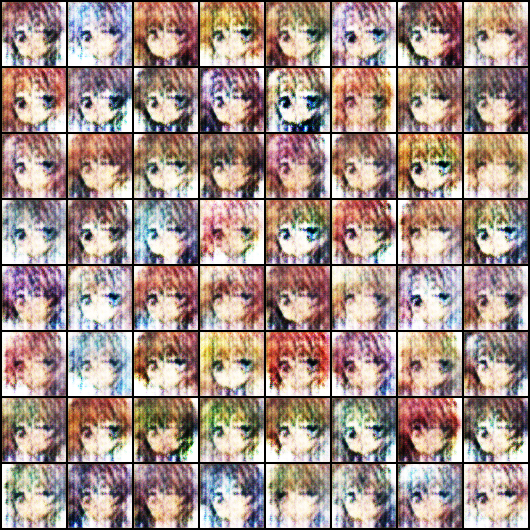

In [37]:
Image('./generated/generated-images-0001.png')

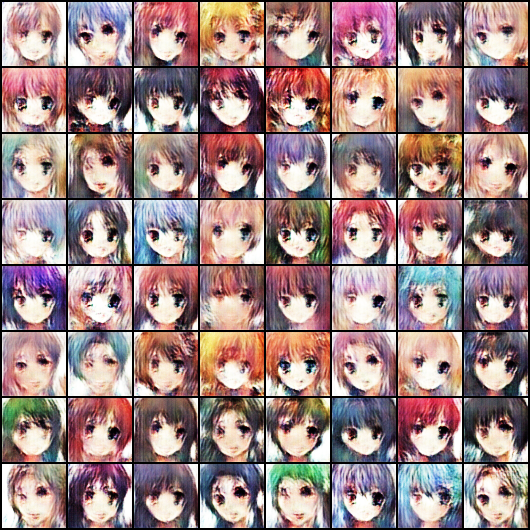

In [40]:
Image('./generated/generated-images-0007.png')

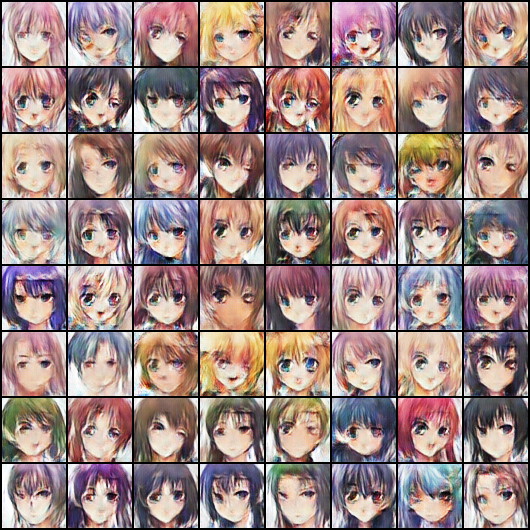

In [41]:
Image('./generated/generated-images-0010.png')

In [42]:
# We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

## Training in one video

![giphy1](https://media.giphy.com/media/117RWY0KwlgNihkHg6/giphy.gif)

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

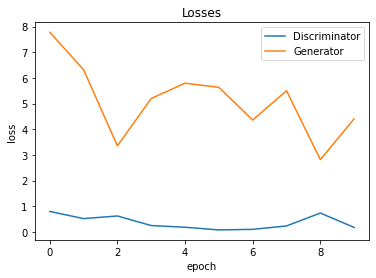

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

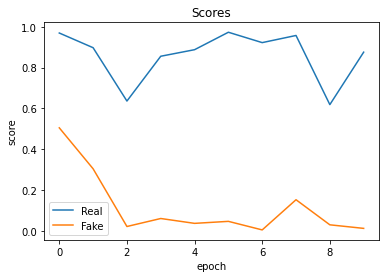

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');